If you would like more explanation to Data preparation part, please go to cDNA_subwords_vocab64 notebook.

# Setup

In [1]:
!pip show fastai

Name: fastai
Version: 2.2.7
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: matplotlib, pip, requests, pillow, torchvision, torch, fastprogress, pyyaml, fastcore, spacy, scikit-learn, pandas, packaging, scipy
Required-by: 


In [2]:
!pip show biopython

Name: biopython
Version: 1.78
Summary: Freely available tools for computational molecular biology.
Home-page: https://biopython.org/
Author: The Biopython Contributors
Author-email: biopython@biopython.org
License: UNKNOWN
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy
Required-by: bio


In [3]:
from Bio import SeqIO
from fastai.text.all import *

# Data preparation

In [4]:
!wget -nc http://ftp.ensembl.org/pub/release-103/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.abinitio.fa.gz
!yes n | gunzip Homo_sapiens.GRCh38.cdna.abinitio.fa.gz

File ‘Homo_sapiens.GRCh38.cdna.abinitio.fa.gz’ already there; not retrieving.

gzip: Homo_sapiens.GRCh38.cdna.abinitio.fa already exists;	not overwritten
yes: standard output: Broken pipe


# Token preparation

In [5]:
with open("Homo_sapiens.GRCh38.cdna.abinitio.fa", "rt") as handle:
  txts = L(str(record.seq).lower() for record in SeqIO.parse(handle, "fasta"))

In [6]:
txt = txts[0]
txts = txts[1:10001]

In [7]:
SPECIAL_TOKENS = 2
ALPHABET = 4
VOCAB_SIZE = 4096 + SPECIAL_TOKENS + ALPHABET
tokenizer = SubwordTokenizer(vocab_sz=VOCAB_SIZE, special_toks=[], cache_dir='tmp/vocab4096', lang='dna')
tokenizer.setup(txts)

{'sp_model': Path('tmp/vocab4096/spm.model')}

In [8]:
toks = first(tokenizer([txt]))
print(coll_repr(toks, 30))

(#192) ['▁atgg','aaagagga','aagaagaaa','agaattt','ccaat','aagtta','caacaa','acttt','tcaccat','tctaa','agaa','ccca','ctt','tcctt','atcaac','caagctg','ggcttc','tctct','agtga','ctcct','attct','agcct','ttccc','cagaaaca','gagag','tgttaa','tcctgg','tgaaaat','ataaaga','cagacac'...]


In [9]:
txt[:100]

'atggaaagaggaaagaagaaaagaatttccaataagttacaacaaacttttcaccattctaaagaacccactttccttatcaaccaagctgggcttctct'

In [10]:
tkn = Tokenizer(tokenizer, rules=[], sep='')
print(coll_repr(tkn(txt), 30))

(#192) ['▁atgg','aaagagga','aagaagaaa','agaattt','ccaat','aagtta','caacaa','acttt','tcaccat','tctaa','agaa','ccca','ctt','tcctt','atcaac','caagctg','ggcttc','tctct','agtga','ctcct','attct','agcct','ttccc','cagaaaca','gagag','tgttaa','tcctgg','tgaaaat','ataaaga','cagacac'...]


In [11]:
toks_all = txts.map(tkn)

# Tokens analysis

In [12]:
from operator import add

tokens = reduce(add, toks_all)

## Top 10 most common tokens

In [14]:
import collections

elements_count = collections.Counter(tokens)
print(elements_count.most_common(10))

[('tga', 13305), ('tag', 6872), ('taa', 6730), ('ctga', 6433), ('atga', 5975), ('ag', 5479), ('ttga', 4331), ('tgtga', 4258), ('ga', 4086), ('agtga', 4038)]


All ten most common tokens correnspond to stop codons.

## Distribution of occurences

In [15]:
counts = []
for count in elements_count:
    counts.append(elements_count[count])

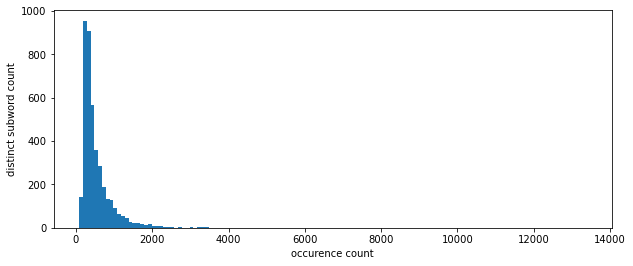

In [16]:
from matplotlib import pyplot

pyplot.figure(figsize=(10,4))
pyplot.hist(counts, bins=range(min(counts), max(counts) + 100, 100))
pyplot.xlabel("occurence count")
pyplot.ylabel("distinct subword count")
pyplot.show()

## Distribution of lengths of subwords

In [17]:
lengths = []
vocab = set(tokens)
for token in vocab:
    lengths.append(len(token))

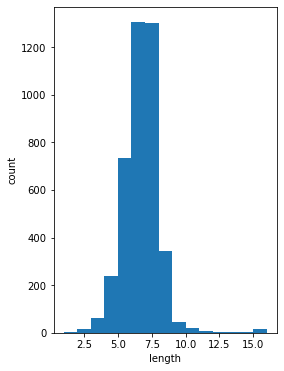

In [18]:
from matplotlib import pyplot

pyplot.figure(figsize=(4,6))
pyplot.hist(lengths, bins=range(min(lengths), max(lengths) + 1, 1))
pyplot.xlabel("length")
pyplot.ylabel("count")
pyplot.show()

## Longest words in vocabulary

In [19]:
vocab = list(vocab)
vocab.sort(key=len)

In [20]:
print(vocab[-1])
print(vocab[-2])
print(vocab[-3])
print(vocab[-4])

atcatcatcgaatgga
accatcaccaccatca
aatggaatcgaatgga
aatggaattgaatgga


Longest subwords looks pretty much like repeats. And two of them differ only in one letter.

## Least freaquent subwords in training data

In [22]:
print(elements_count.most_common()[-1])
print(elements_count.most_common()[-2])
print(elements_count.most_common()[-3])
print(elements_count.most_common()[-4])

('aatggactcgaatgga', 80)
('t', 92)
('aatggaattgaatgga', 105)
('accatcaccaccatca', 114)


Longest subwords are starting to became the least frequent subwords - I think that this is too large vocab size for current data.